# APC CAS_KAGGLE STUDENT GRADES

* JAN PLANAS BATLLORI
* NIU: 1636492

### Student Alcohol Consumption

[Kaggle Dataset](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption/data)

En aquest fitxer resoldre un problema de regressió el qual haurè de predir les notes de matemàtiques i de portugues dels alumnes. 

#### INCLUDES

In [4]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

### FUNCTIONS

In [5]:
def show_correlations(numerics_norm, binary, df):
    numericsG1 = numerics_norm.copy()
    numericsG1.extend(binary.copy())
    numericsG2 = numerics_norm.copy()
    numericsG2.extend(binary.copy())
    numericsG3 = numerics_norm.copy()
    numericsG3.extend(binary.copy())

    numericsG1.insert(0, 'G1')
    numericsG2.insert(0, 'G2')
    numericsG2.insert(1, 'G1')
    numericsG3.insert(0, 'G3')
    numericsG3.insert(1, 'G1')
    numericsG3.insert(2, 'G2')

    correlation_matrix_G1 = df[numericsG1].corr()
    first_row_correlation_G1 = correlation_matrix_G1.iloc[[0]]

    correlation_matrix_G2 = df[numericsG2].corr()
    first_row_correlation_G2 = correlation_matrix_G2.iloc[[0]]

    correlation_matrix_G3 = df[numericsG3].corr()
    first_row_correlation_G3 = correlation_matrix_G3.iloc[[0]]

    plt.figure(figsize=(15, 6))

    plt.subplot(3, 1, 1)
    sns.heatmap(first_row_correlation_G1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G1')

    plt.subplot(3, 1, 2)
    sns.heatmap(first_row_correlation_G2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G2')

    plt.subplot(3, 1, 3)
    sns.heatmap(first_row_correlation_G3, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Primera fila de la matriz de correlación - G3')

    plt.tight_layout()
    plt.show()
    
    return [first_row_correlation_G1, first_row_correlation_G2, first_row_correlation_G3]

In [6]:
def get_correlations(first_row_correlation, threshold):
    positive_correlation = first_row_correlation[first_row_correlation > threshold].dropna(axis=1)
    attributes_with_positive_corr = positive_correlation.columns.tolist()
    attributes_with_positive_corr = attributes_with_positive_corr[1:]
    
    return attributes_with_positive_corr

In [7]:
def normalitzar(data):
    # Dividir los datos en train y test
    train = data[0]
    test = data[1]
    numerics = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    for nums in numerics:
        df[nums] = np.log1p(df[nums])
    scaler = MinMaxScaler()
    
    train[numerics] = scaler.fit_transform(train[numerics])

    test[numerics] = scaler.transform(test[numerics])
    
    return train, test

In [2]:
def encoder(data):
    # Dividir los datos en train y test
    train = data[0]
    test = data[1]
    binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
    non_binary = ['Mjob', 'Fjob', 'reason', 'guardian']
    label_encoder = LabelEncoder()
    for attr in binary:
        encoded_values = label_encoder.fit_transform(train[attr])
        train[attr] = encoded_values
        encoded_values = label_encoder.transform(test[attr])
        test[attr] = encoded_values
        
    encoder = OneHotEncoder(sparse=False)
    
    encoder.fit(train[non_binary])
    attribute_encoded = encoder.fit_transform(train[non_binary])

    new_column_names = encoder.get_feature_names_out(input_features=non_binary)
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=train.index)

    train = train.drop(non_binary, axis=1)
    train = pd.concat([train, encoded_df], axis=1)
   
    attribute_encoded = encoder.transform(test[non_binary])

    new_column_names = encoder.get_feature_names_out(input_features=non_binary)
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=test.index)

    test = test.drop(non_binary, axis=1)
    test = pd.concat([test, encoded_df], axis=1)
    return train, test

### EDA

In [8]:
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

df = pd.concat([math_data, por_data], ignore_index=True)
df['math_data'] = 0  # Inicializar la columna 'is_math_data' con 0
df.loc[:len(math_data), 'math_data'] = 1  # Marcar las filas correspondientes a math_data con 1

df['por_data'] = 0  # Inicializar la columna 'is_por_data' con 0
df.loc[len(math_data):, 'por_data'] = 1
df_mostra = df.copy()
df.info()
print(f"El shape del train-data es {df.shape}.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

In [9]:
print(df.isna().sum().sum())

0


Farem un primer anàlisi dels atribut que tenim i els calssificarem en categòrics i numèrics.  

In [10]:
categorics = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerics = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
targets = ['G1', 'G2', 'G3']

Dins dels atributs categòrics els diferenciarem entre binaris i no binaris.

In [11]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
non_binary = ['Mjob', 'Fjob', 'reason', 'guardian']

Balanceig numerics.

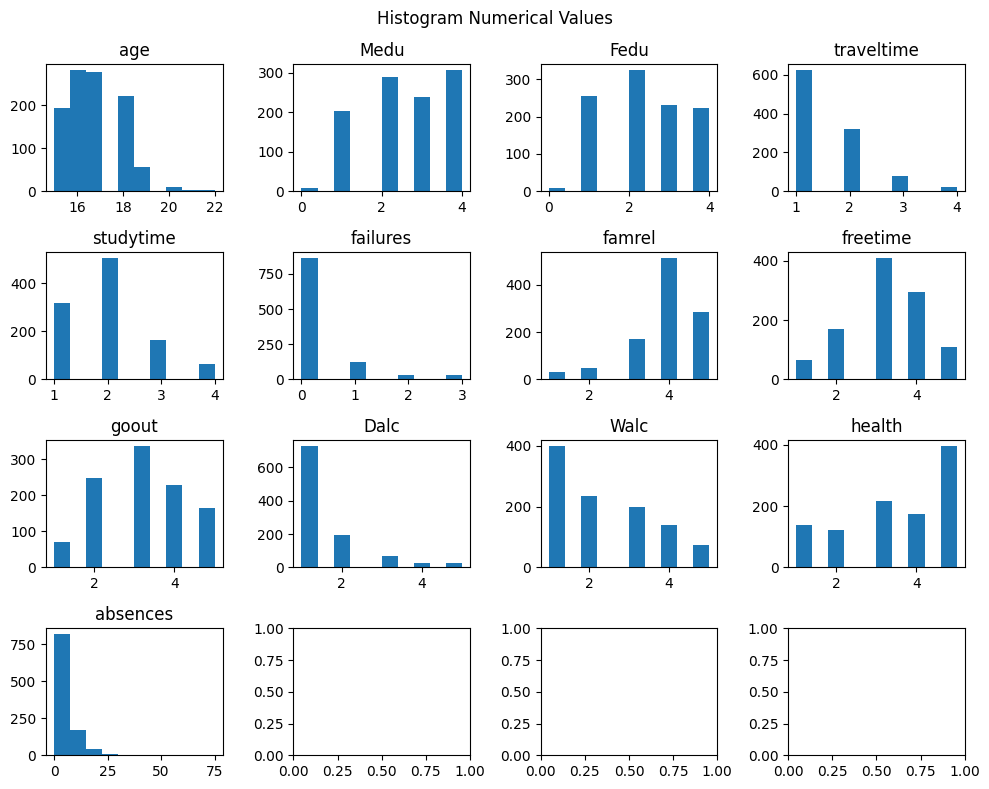

In [30]:
df_num = df[numerics]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Balanceig categorics.

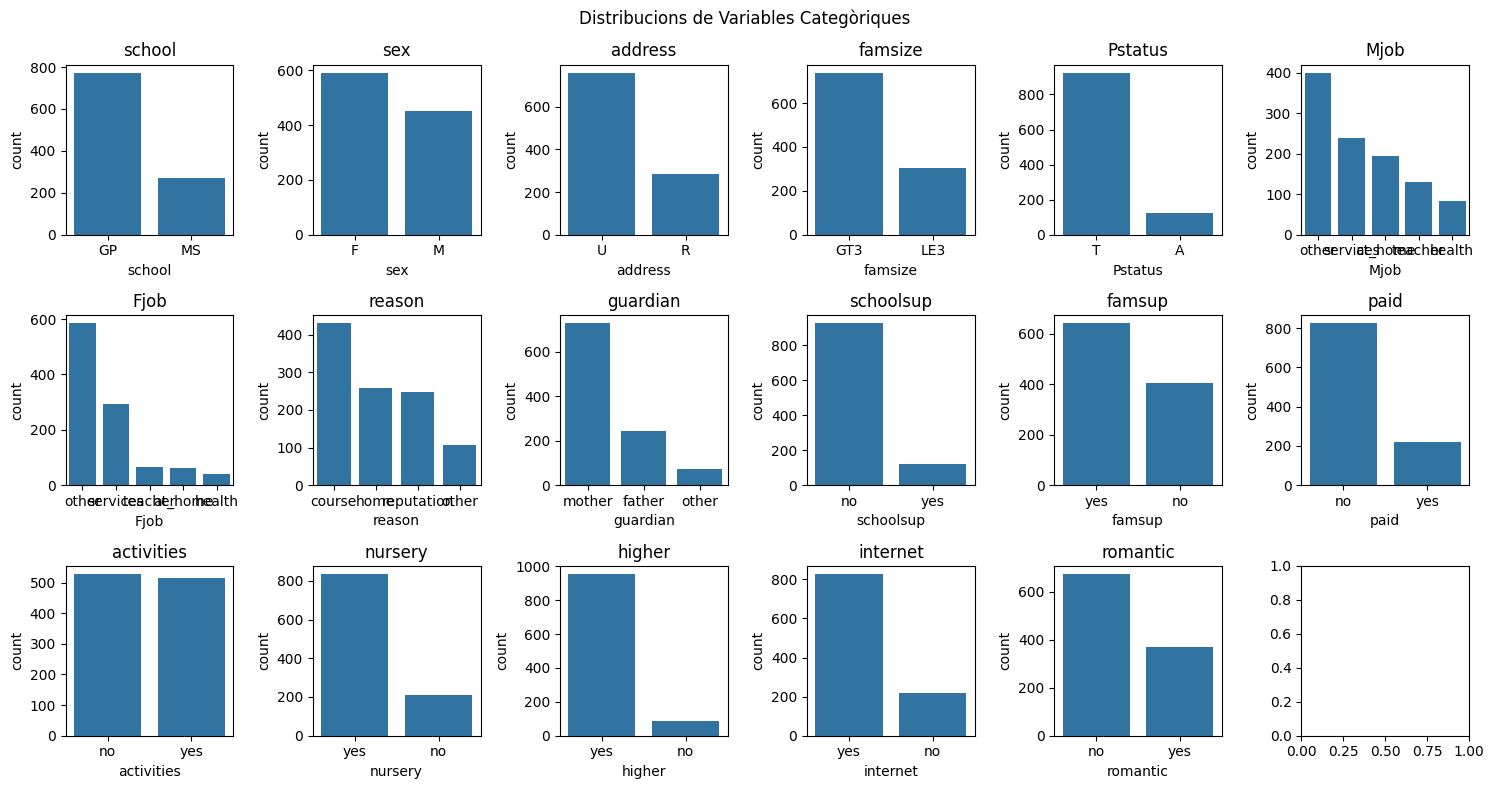

In [31]:
df_cat = df[categorics]
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
fig.suptitle('Distribucions de Variables Categòriques')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_ylabel('count')
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Balanceig targets.

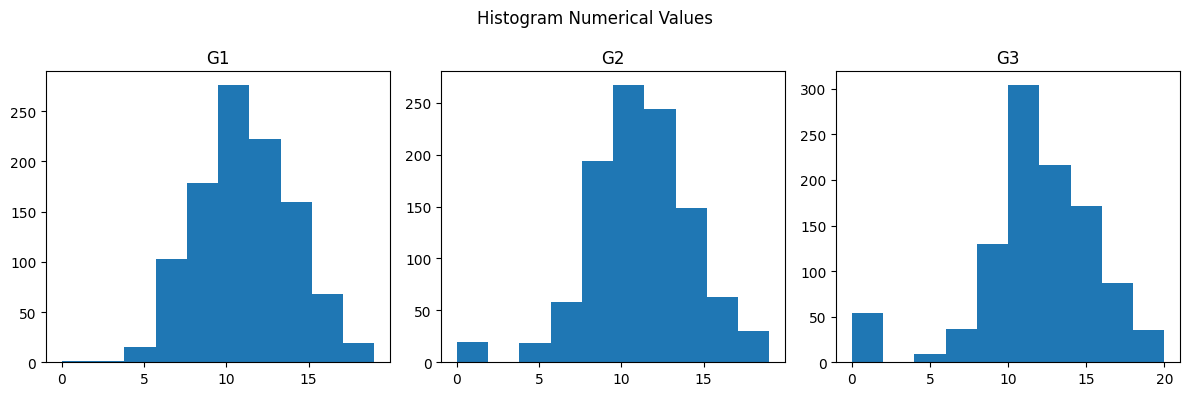

In [32]:
df_targ = df[targets]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_targ.columns, axes.ravel()):
    ax.hist(df_targ[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Correlacions

In [12]:
df_correlations = df.copy()
df_extra = df.copy()
df_correlations, df_extra = normalitzar([df_correlations, df_extra])
df_correlations, df_extra = encoder([df_correlations, df_extra])

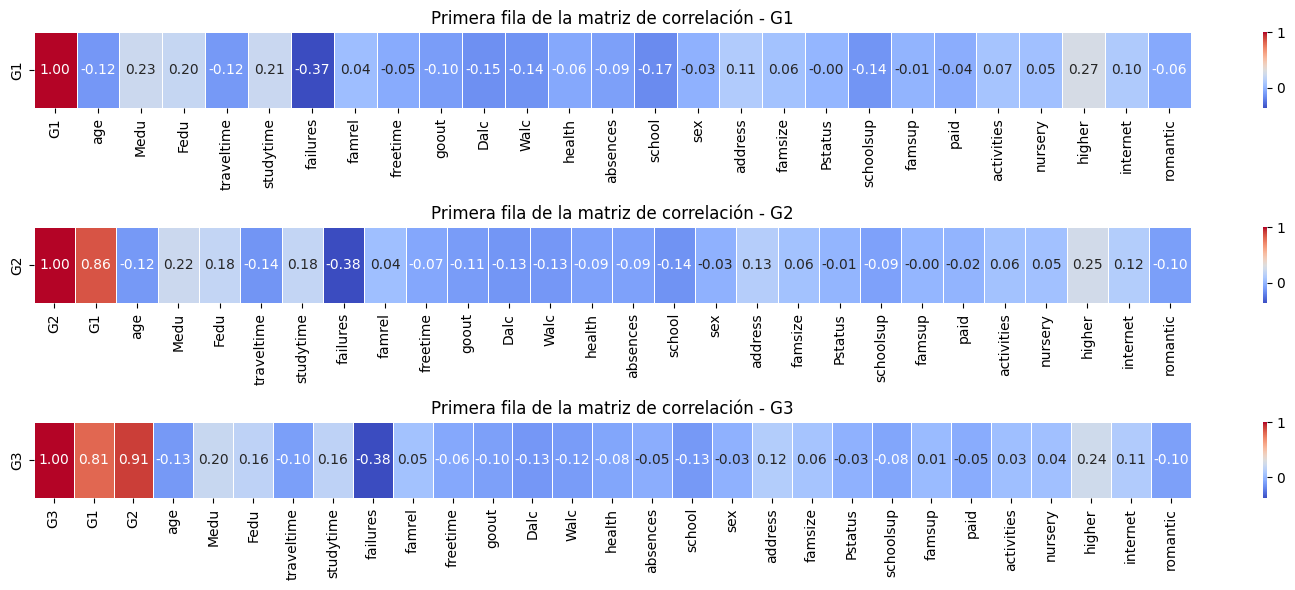

In [34]:
correlations = show_correlations(numerics, binary, df_correlations)

In [35]:
atributes_correlation = get_correlations(correlations[2], threshold=0)

## PROCESSING

#### NORMALITZACIO

El primer que fare serà normalitzar logaritmicament les dades per a que tingui una distribució normal el més semblant possible. Seguidament, escalare les dades per a que vagin de 0 a 1 com a minim i màxim, amb el Min-Max Scaling.

La normalització logarítmica s'utilitza per transformar dades amb distribucions sesgades o una ampla variabilitat, reduint el sesgament i l'amplitud dels valors. Ajudar a igualar la distribució, estabilitzar la variància, facilitar la interpretació i preparar les dades per a certs models, però la seva aplicabilitat depèn de la naturalesa de les dades i del context del problema.

La funció principal del MinMaxScale és escalar les dades entre un rang específic, en aquest cas entre 0 i 1.  
El MinMaxScaler es una técnica de escalado que transforma los datos de tal manera que quedan en un rango específico, generalmente entre 0 y 1. Ens facilita la seva comparació ja que tots les variables categoriques tenen el mateix rang de dades.

In [36]:
def show_numerics(numerics_norm, df):
    df_num = df[numerics_norm]
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
    fig.suptitle('Histogram Numerical Values')

    for i, ax in zip(df_num.columns, axes.ravel()):
        ax.hist(df_num[i], bins=10)
        ax.set_title(i)

    plt.tight_layout()

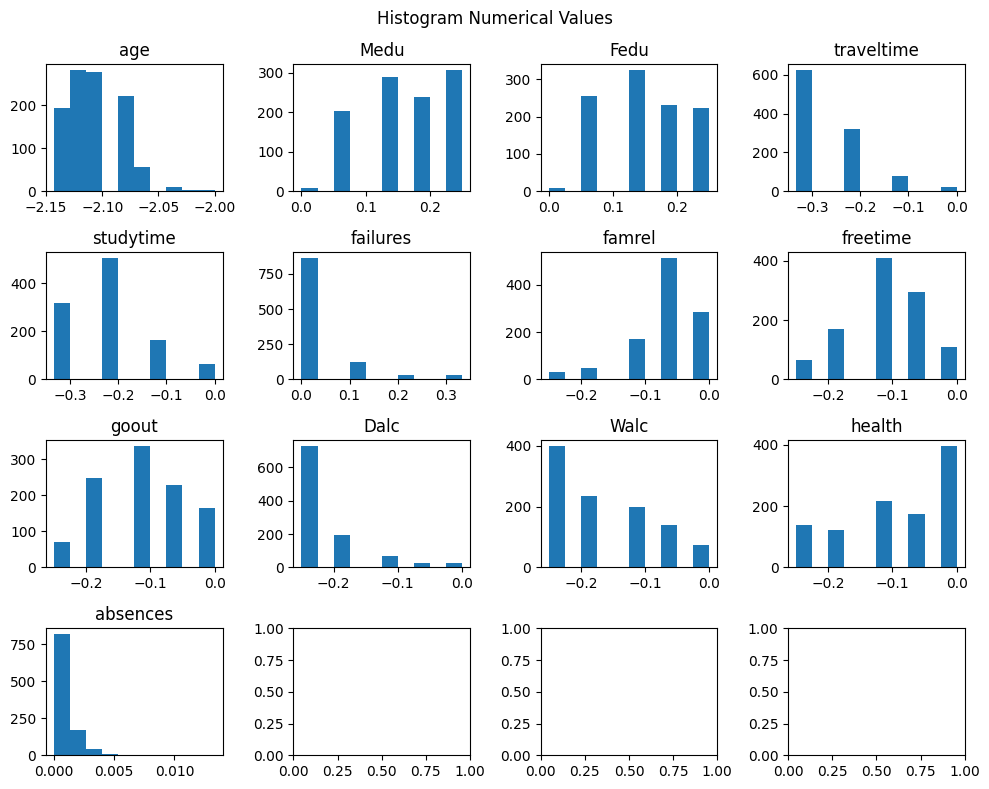

In [37]:
df_mostra, _ = normalitzar([df_mostra, df_mostra])
show_numerics(numerics, df_mostra)

#### ENCODING

Per a aquest apartat he decidit fer dos tipus d'encoding. Fare sevir el LabelEncoder per als atributs binaris i el OneHotEncoding per als altre.  
Això ho faig perque el LabelEncoder pot, avegades, afegir un ordre intrinsic que no existeix realment en les dades del dataset i es per això que pels atributs que no son binaris he decidit fer servir el OneHotEncoder. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Això fa que la dimensionalitat del dataset augmenti molt per això amb les binaries faré un LabelEncoder.

In [15]:
not_enc = numerics.extend(['G1', 'G2', 'G3'])
enc = df_correlations.drop(numerics, axis=1)
enc.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,1,0,0,1,0,0,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,1,0,1,0,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,1,1,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,1,0,1,0,1,1,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,1,0,1,0,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### OUTLIERS

In [39]:
def show_outliers(df, target):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[target], flierprops=dict(markerfacecolor='r', marker='D'))
    plt.show()

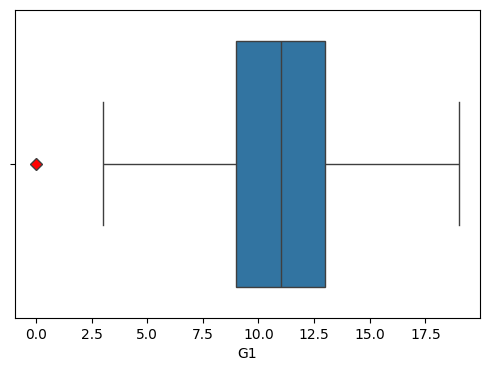

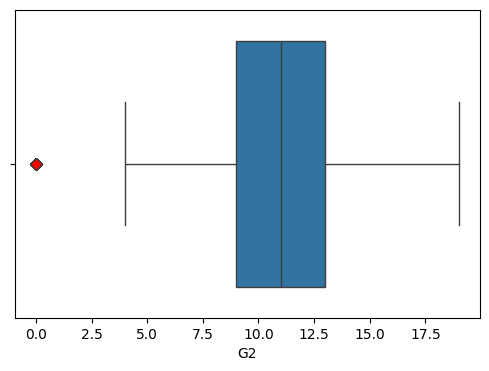

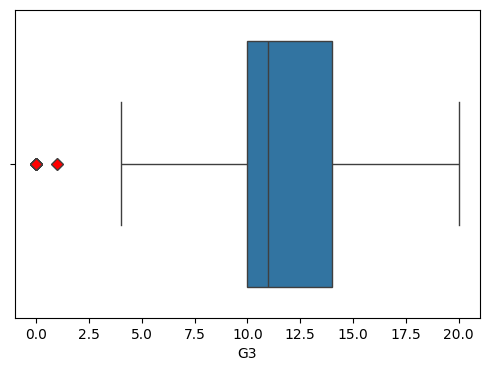

In [40]:
for target in targets:
    show_outliers(df, target)

In [41]:
def get_valors_outliers(df, target):
    outliers = df[target]

    Q1 = np.percentile(outliers, 25)
    Q3 = np.percentile(outliers, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_indices = df[(df[target] < lower_bound) | (df[target] > upper_bound)].index

    return outliers_indices

def outliers_iguals(outliers1, outliers2):
    return all(outlier in outliers2 for outlier in outliers1)

In [42]:
outliers = {'G1' : 0, 'G2' : 0, 'G3' : 0}

for k in outliers.keys():
    outliers[k] = get_valors_outliers(df, k)


In [43]:
def treure_outliers(outliers, df):
    df = df.drop(outliers, axis=0)

TREURE OUTLIERS

In [44]:
for out1 in outliers.values():
    for out2 in outliers.values():
        if outliers_iguals(out1, out2):
            break
        else:
            treure_outliers(out1, df)
            break        

### 3. MODEL SELECTION AMB CV

En aquest apartat entrenare 6 models diferents de regressió. Aquests són: LinearRegression, SVR, RandomForestRegression, Ridge, Lasso i GradientBoostingRegressor.  Els avaluare segons la mètrica de r2-score per decidir quin és el millor.

Per entrenar-los fare servir el cross validation i, posteriorment, fare una cerca d'hiperparàmetres per a que els models puguin ser el mes precisos posible.

És important fer servir la validació creuada a l'entrenament dels models per evitar possibles Overfittings o Underfittings.

Una decisió important a la validació és la selecció d'un bon hyperparametre n_splits que és equivalent a la k. Un valor petit com 3 o 5 pot tenir un cost computacional bastant baix, però a la vegada pot provocar major variança i bias. En canvi, un valor alt com 10, encara que té més cost computacional, a canvi tindrà menys variança i bias, aixó doncs obtenim mesures més estables i representatives. 

In [45]:
def pred_simple(df, target, drops):
    X = df.drop(drops, axis=1) 
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, X_test = normalitzar((X_train, X_test))
    X_train, X_test = encoder((X_train, X_test))
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse, " R2 Score:", r2, '\n')
    return y_test, y_pred

datasets = {'df combinat' : df, 'df matematiques' : math_data, 'por_data' : por_data}
results = {}
targets = [('G2', ['G2', 'G3']), ('G3', ['G2', 'G3']), ('G3', ['G3'])]

for target in targets:
    for name, df in datasets.items():
        print('Analitzant ', name, ' target ', target[0], 'drops', target[1])
        y_test, y_pred = pred_simple(df, target[0], target[1])
        results[name] = (y_test, y_pred)

Analitzant  df combinat  target  G2 drops ['G2', 'G3']
Mean Squared Error: 2.5201977735506116  R2 Score: 0.7558078160304293 

Analitzant  df matematiques  target  G2 drops ['G2', 'G3']
Mean Squared Error: 3.2771193480291285  R2 Score: 0.778922382082946 

Analitzant  por_data  target  G2 drops ['G2', 'G3']


Mean Squared Error: 2.4796964306097764  R2 Score: 0.7488039492816697 

Analitzant  df combinat  target  G3 drops ['G2', 'G3']
Mean Squared Error: 5.059614033204033  R2 Score: 0.6589725341823501 

Analitzant  df matematiques  target  G3 drops ['G2', 'G3']
Mean Squared Error: 8.183115987928913  R2 Score: 0.6277366763092014 

Analitzant  por_data  target  G3 drops ['G2', 'G3']
Mean Squared Error: 3.44353282726728  R2 Score: 0.688597632841906 

Analitzant  df combinat  target  G3 drops ['G3']
Mean Squared Error: 2.7681683313508496  R2 Score: 0.813420267869831 

Analitzant  df matematiques  target  G3 drops ['G3']
Mean Squared Error: 4.596840351444333  R2 Score: 0.790882217699355 

Analitzant  por_data  target  G3 drops ['G3']
Mean Squared Error: 1.4007482773934055  R2 Score: 0.873328830810338 



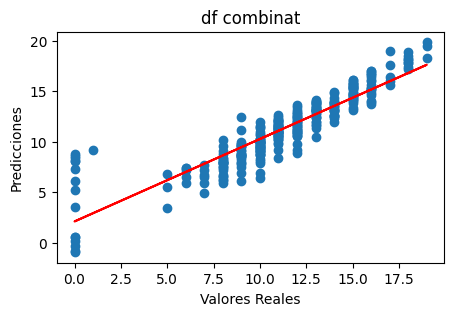

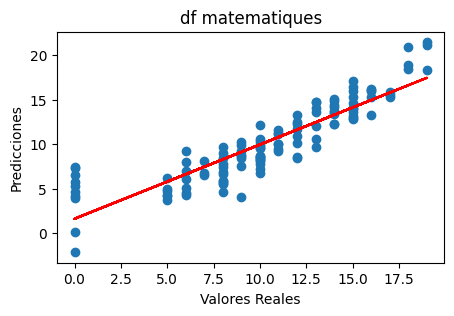

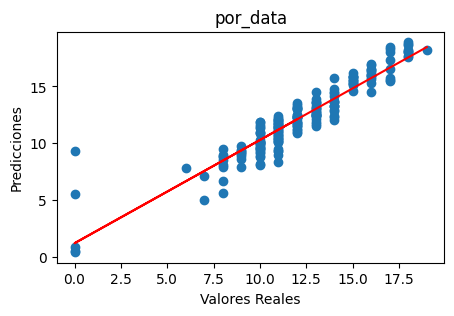

In [46]:
def veure_preds(results):
    for name, res in results.items():
        coef = np.polyfit(res[0], res[1], deg=1)
        poly1d_fn = np.poly1d(coef)
        plt.figure(figsize=(5, 3))
        plt.scatter(res[0], res[1])
        plt.plot(res[0], poly1d_fn(res[0]), color='red')  # Línea roja es la línea de regresión
        plt.xlabel('Valores Reales')
        plt.ylabel('Predicciones')
        plt.title(name)
        plt.show()
veure_preds(results)

In [47]:
models_scores = {'Sense hyperparametres': {'SVR': 0, 'LR': 0, 'RF': 0, 'GBR': 0, 'Lasso' : 0, 'Ridge' : 0}, 'Amb hyperparametres': {'SVR': 0, 'LR': 0, 'RF': 0, 'GBR': 0, 'Lasso' : 0, 'Ridge' : 0}}

classifiers = {'SVR': SVR(), 'LR': LinearRegression(), 'RF': RandomForestRegressor(), 'GBR' : GradientBoostingRegressor(), 'Lasso' : Lasso(), 'Ridge' : Ridge()}

kfold = KFold(n_splits=5, shuffle=True, random_state=135)

X = df.drop(['G3'], axis=1)
y = df['G3']

def avaluacio_models_k_fold(model, kfold, models_scores, model_name):
    r2_acc = []
    mse_acc = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train, X_test = normalitzar((X_test, X_train))
        X_train, X_test = encoder((X_test, X_train))
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2_acc.append(r2)
        mse_acc.append(mse)
    scores = {'r2' : np.array(r2_acc).mean(), 'mse' : np.array(mse_acc).mean()}
    models_scores['Sense hyperparametres'][model_name] = scores

for model_name, model in classifiers.items():
    avaluacio_models_k_fold(model, kfold, models_scores, model_name)

In [48]:
res = pd.DataFrame(models_scores["Sense hyperparametres"])
res

,SVR,LR,RF,GBR,Lasso,Ridge
r2,0.805600,0.836314,0.826767,0.811969,0.831416,0.837025
mse,2.015797,1.680246,1.771786,1.909471,1.745073,1.673326


#### Cerca d'hyperparametres

Escollir els paràmetres idonis per entrenar el model pot ser una tasca tediosa. Existeixen per això tècniques que et troben la millor combinació d'hyperparametres possible. Aquests són alguns com GridSearchCV, RandomizedSearchCV o HalvingRandomSearchCV.

En termes de cost computacional, podem dir que la primera és la més costosa per la seva exhaustivitat al provar cada combinació possible. Les dues altres opcions, molt menys costoses, poden resultar més eficients en segons que aspectes, però hem de tenir en compte que necessitem la millor combinació possible de hyperparametres. Així doncs, escollire el GridSearch.

In [49]:
X = df.drop(['G3'], axis=1)
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(Ridge(), param_grid={
        'alpha': [0.1, 0.2, 0.5, 0.7, 1.0, 1.2, 1.5],
        'fit_intercept': [True, False],
        'solver'  : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
        'positive' : [True, False],
        'random_state' : [None, 42, 154, 236],
        'tol' : [0.0001, 0.0005, 0.001, 0.005, 0.01],
        'max_iter' : [None, 1000, 5000, 10000]
    }, scoring={
    'r2': 'r2',
    'mse': make_scorer(mean_squared_error, greater_is_better=False)  # menor MSE es mejor
}, cv=kfold, verbose=True, n_jobs=-1, refit='r2')

X_train, X_test = normalitzar((X_test, X_train))
X_train, X_test = encoder((X_test, X_train))

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
duration = end_time - start_time

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, '\n Best r2: ', best_score)

Fitting 5 folds for each of 17920 candidates, totalling 89600 fits
{'alpha': 1.5, 'fit_intercept': False, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'sparse_cg', 'tol': 0.001} 
 Best r2:  0.8443781879033695


In [84]:
X = df.drop(['G3'], axis=1)
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train, X_test = normalitzar((X_test, X_train))
X_train, X_test = encoder((X_test, X_train))

best_model = Ridge(**best_params)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R2 Score: ', round(r2, 2))

mse = mean_squared_error(y_test, y_pred)
print('MSE: ', round(mse, 2))

R2 Score:  0.85
MSE:  1.71


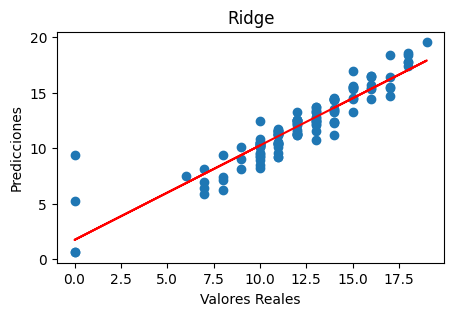

In [85]:
veure_preds({'Ridge' : (y_test, y_pred)})